## Introduction
This notebook loads ChiWUG's additional sense annotation and creates cluster stats and change scores.

In [1]:
# import scripts from parent folder
import sys
sys.path.append('../')

import os
from pathlib import Path

output_path = '../../data/chiwug_sense_1.0.0'
Path(output_path).mkdir(parents=True, exist_ok=True)

### Load data

In [2]:
# reference data set for experiments: ChiWUG (V1.0.0)
import requests
chiwug = 'https://zenodo.org/records/10023263/files/chiwug.zip?download=1'
r = requests.get(chiwug, allow_redirects=True)
f = 'chiwug.zip'
open(f, 'wb').write(r.content)

import zipfile
with zipfile.ZipFile(f) as z:
    z.extractall()

In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
import shutil
import unicodedata

dataset_path = 'chiwug'
dataset_sense_path = '../../data/chiwug_sense_1.0.0/data_original'

# Extract grouping (time) information
df_chiwug_uses = pd.DataFrame()
for p in Path(dataset_path+'/data').glob('*/uses.csv'):
    lemma = str(p).split('/')[-2]        
    lemma = unicodedata.normalize('NFC', lemma)
    df = pd.read_csv(p, delimiter='\t', quoting=3, na_filter=False)
    df['identifier'] = df['identifier'].astype(str) + '-' + lemma # make sure identifiers are unique across words
    df_chiwug_uses = pd.concat([df_chiwug_uses, df]) # not used for now, if used below need to match lemmas
display(df_chiwug_uses)   

,lemma,pos,date,grouping,identifier,description,context,indexes_target_token,indexes_target_sentence
0,憋,zg,2000,2,2000-93-憋,,有五六个女子同时围住了我，有拉手的，有抱腰的，一个大胖女子无处可抓，猛伸手薅住了我的衣领，憋...,45:46,0:56
1,憋,zg,1975,1,1975-16-憋,,这时，井口的天然气压力急剧上升，随时有把井口憋破的危险,22:23,0:27
2,憋,zg,1970,1,1970-8-憋,,这件事，使农具厂的工人憋了一股劲，说：“到人家锅里盛饭，吃不香；靠别人扶着走路，不得劲,11:12,0:43
3,憋,zg,1997,2,1997-90-憋,,左心衰的“喘”常在睡眠中突然憋醒后发生，平卧位时“喘”明显加剧，端坐位时“喘”减轻；而支气管...,14:15,0:63
4,憋,zg,1978,1,1978-48-憋,,君不见：那阴暗的角落里，磷火般的昏黄灯下，正在采排一幕篡党夺权、称帝登基的丑剧……啊，我的心...,49:50,0:76
...,...,...,...,...,...,...,...,...,...
35,急,v,1959,1,1959-25-急,,逼得高二锁急了，提出大家都来当队长，有事情共同商量,5:6,0:25
36,急,v,2002,2,2002-77-急,,在农村“三个代表”学习教育活动中，宜宾城区供电局急农民所急，把这13个村定为农网改造的重点地...,24:25,0:76
37,急,v,1970,1,1970-32-急,,施焕臣急得吃不下饭，睡不好觉,3:4,0:14
38,急,v,1990,2,1990-76-急,,想群众所想，急群众所急，扎扎实实为群众办实事，把党的温暖送到群众心上，正是为了让群众从切身利...,6:7,0:94


In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

def extract_majority_label(labels, threshold):
    """
    Gets the majority label from a list of labels.
    :param labels: labels
    :param threshold: minimum threshold for number of occurrences of majority label
    :return label: majority label
    """
    labels_old = list(labels)
    labels = []
    for label in labels_old:
        try:
            labels.append(int(label))
        except ValueError:
            pass
        
    label2count = Counter(labels)
    majority_labels = [l for l, c in label2count.items() if c >= threshold]
    if len(majority_labels) > 0:
        label = np.random.choice(majority_labels)
    else:
        #print(label2count)
        label = np.NaN  
    return label

# Load word sense annotation
df_chiwug_senses = pd.DataFrame()
for p in Path(dataset_sense_path+'/').glob('*.csv'):
    if 'chiwug-target-sense.csv' in str(p):
        continue
    #print(p)
    judgments = pd.read_csv(p, dtype={'annotator1': str, 'annotator2': str, 'annotator3': str})
    lemma = judgments['lemma'][0]  
    judgments['identifier'] = judgments['identifier'].astype(str) + '-' + lemma # make sure identifiers are unique across words
    #display(judgments[['annotator1','annotator2','annotator3']].apply(lambda x: list(x)).values)
    judgments['judgments'] = judgments[['annotator1','annotator2','annotator3']].apply(lambda x: list(x)).values.tolist()
    #display(judgments).blah
    df_chiwug_senses = pd.concat([df_chiwug_senses, judgments])
df_chiwug_senses = df_chiwug_senses.reset_index()    
#display(df_chiwug_senses)

# Extract majority labels for sense annotation
threshold = 3 # threshold for majority labels
df_chiwug_senses['identifier_sense'] = df_chiwug_senses['judgments'].apply(lambda x: extract_majority_label(list(x), threshold)) # add majority label column
df_chiwug_senses['identifier_sense'] = df_chiwug_senses['identifier_sense'].fillna(-1)
#display(df_chiwug_senses)

In [5]:
# inspect
display(df_chiwug_senses[df_chiwug_senses['lemma'] == '窗口'].head())

,index,lemma,pos,date,grouping,identifier,description,context,indexes_target_token,indexes_target_sentence,identifier_system,annotator1,annotator2,annotator3,judgments,identifier_sense
1240,0,窗口,s,1958,1,1958-4-窗口,,一阵阵汽车声、拖拉机声从席棚的窗口透进来,15:17,0:20,533673,1,1,1,"[1, 1, 1]",1.0
1241,1,窗口,s,2003,2,2003-73-窗口,,"真诚地希望广大读者就这些问题,提供内容健康向上、见解精辟独到、语言生动活泼、篇幅短小精悍,有...",87:89,0:89,533672,4,4,4,"[4, 4, 4]",4.0
1242,2,窗口,s,1995,2,1995-71-窗口,,"城市也是一个地区物质文明和精神文明建设的“窗口”,集中反映了一个地区的文明程度",21:23,0:39,533655,4,4,4,"[4, 4, 4]",4.0
1243,3,窗口,s,1963,1,1963-24-窗口,,"武汉市第三医院修改和健全了一些医疗制度,简化了就医手续,药房在不增加人员的条件下增设了一个发...",47:49,0:60,533678,3,3,3,"[3, 3, 3]",3.0
1244,4,窗口,s,1961,1,1961-38-窗口,,"陈博紧握着手把,稳住被颠簸得左右摇晃的身子,全神贯注地了望着信号,一会儿坐到司机背后,从左窗...",45:47,0:75,533649,2,1,2,"[2, 1, 2]",-1.0


In [6]:
import networkx as nx
from cluster_ import *
from itertools import combinations

node2cluster = dict(zip(df_chiwug_senses['identifier'],df_chiwug_senses['identifier_sense']))
#print(node2cluster).blah

node2grouping = dict(zip(df_chiwug_senses['identifier'],df_chiwug_senses['grouping']))
# Prepare the data
# Group by lemma
gb = df_chiwug_senses.groupby('lemma')    
groups = gb.groups

# Run separately for each lemma
target2graph = {}
for word in groups.keys():
    #print(word)
    df_group = gb.get_group(word)
    graph = nx.Graph()
    graph.add_nodes_from(df_group['identifier'])
    nx.set_node_attributes(graph, {node:{'type':'usage','grouping':str(node2grouping[node]),'cluster':node2cluster[node]} for node in graph.nodes()})   
    edge2weight = [(u,v,int(node2cluster[u] == node2cluster[v])) if (node2cluster[u]!=-1 and node2cluster[v]!=-1) else (u,v,np.nan) for (u,v) in combinations(graph.nodes(), 2)]
    graph.add_weighted_edges_from(edge2weight)   
    target2graph[word] = graph

{'下海': 3, '体系': 1, '停业': 1, '储粮': 1, '出血': 2, '包装': 2, '宰': 3, '急': 4, '憋': 2, '拐': 5, '推出': 2, '插秧': 1, '机制': 3, '浓': 3, '消化': 2, '涨': 2, '滑坡': 2, '潜伏': 1, '火': 3, '灰色': 3, '炒': 2, '热': 5, '熟': 5, '留下': 1, '病毒': 2, '窗口': 4, '窗户': 1, '紫色': 1, '细菌': 1, '绿色': 2, '腌': 1, '言语': 2, '起步': 2, '软': 5, '输血': 2, '退役': 3, '透明': 2, '飞越': 2, '骑车': 1, '鲜艳': 1}


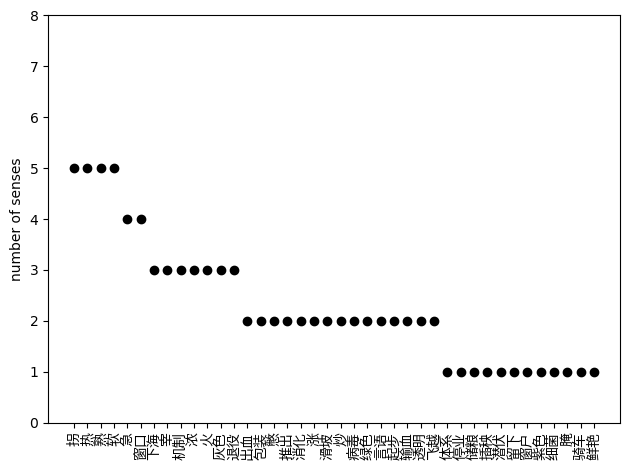

{'下海': 2, '体系': 1, '停业': 1, '储粮': 1, '出血': 1, '包装': 2, '宰': 2, '急': 4, '憋': 1, '拐': 3, '推出': 2, '插秧': 1, '机制': 2, '浓': 3, '消化': 2, '涨': 2, '滑坡': 1, '潜伏': 1, '火': 2, '灰色': 2, '炒': 1, '热': 2, '熟': 3, '留下': 1, '病毒': 1, '窗口': 3, '窗户': 1, '紫色': 1, '细菌': 1, '绿色': 1, '腌': 1, '言语': 2, '起步': 2, '软': 4, '输血': 2, '退役': 2, '透明': 1, '飞越': 2, '骑车': 1, '鲜艳': 1}


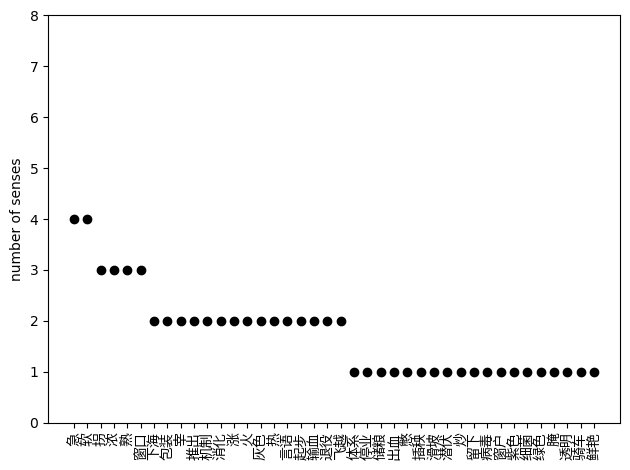

{'下海': 3, '体系': 1, '停业': 1, '储粮': 1, '出血': 2, '包装': 2, '宰': 2, '急': 3, '憋': 2, '拐': 5, '推出': 1, '插秧': 1, '机制': 1, '浓': 2, '消化': 2, '涨': 2, '滑坡': 2, '潜伏': 1, '火': 3, '灰色': 3, '炒': 2, '热': 4, '熟': 5, '留下': 1, '病毒': 2, '窗口': 4, '窗户': 1, '紫色': 1, '细菌': 1, '绿色': 2, '腌': 1, '言语': 2, '起步': 2, '软': 4, '输血': 2, '退役': 3, '透明': 2, '飞越': 1, '骑车': 1, '鲜艳': 1}


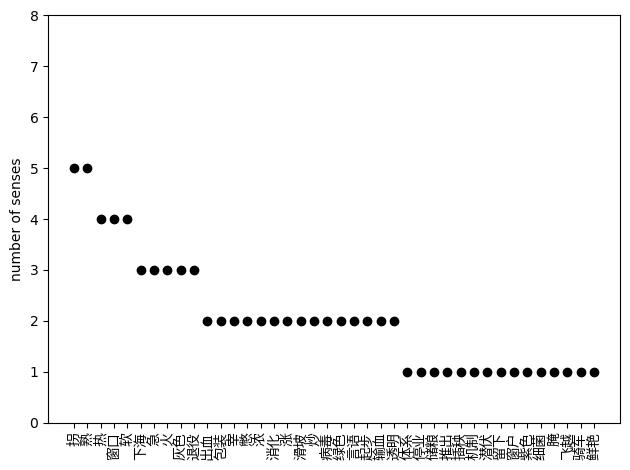

{'下海': 0.6030589656894902, '体系': 0.0, '停业': 0.0, '储粮': 0.0, '出血': 0.29800275079176114, '包装': 0.0854351026245885, '宰': 0.6048555602537689, '急': 0.4928233423313069, '憋': 0.3713830650016636, '拐': 0.2928065430574254, '推出': 0.740806952380577, '插秧': 0.0, '机制': 1.0, '浓': 0.45193374048355284, '消化': 0.2697979710148432, '涨': 0.28607864350487505, '滑坡': 0.702440464210416, '潜伏': 0.0, '火': 0.3367744637501776, '灰色': 0.17426790131800937, '炒': 0.30725308537526586, '热': 0.7692191469665082, '熟': 0.554064072449115, '留下': 0.0, '病毒': 0.22781387210026416, '窗口': 0.7544708885428498, '窗户': 0.0, '紫色': 0.0, '细菌': 0.0, '绿色': 0.5069331210745203, '腌': 0.0, '言语': 0.043758565727619, '起步': 0.3547094886594105, '软': 0.5499829490460085, '输血': 0.14785469913239724, '退役': 0.6234042142388959, '透明': 0.5579230452841438, '飞越': 0.16379530334493164, '骑车': 0.0, '鲜艳': 0.0}


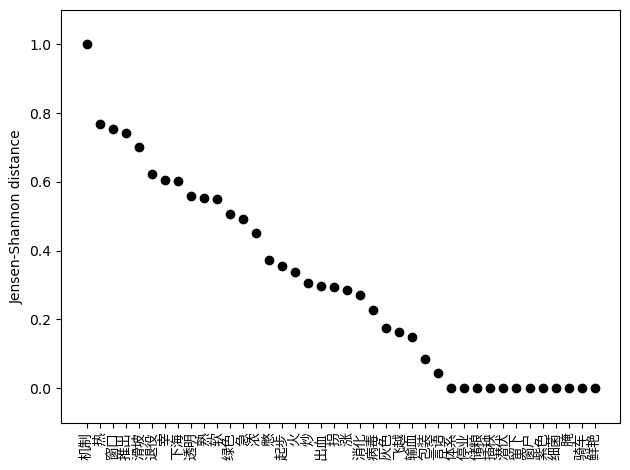

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.font_manager as mfm
font_path = "/usr/share/fonts/google-noto-sans-cjk-fonts/NotoSansCJK-Regular.ttc"
prop = mfm.FontProperties(fname=font_path)
nice_colors = [x for x in mcolors.get_named_colors_mapping().values() if isinstance(x, str)] # Nice colors
colors_global = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00'] # color-blind colors
colors_global = colors_global + nice_colors
from modules import *
import csv

lower_range_min=1
lower_range_max=3
upper_range_min=3
upper_range_max=5
lower_prob=0.01
upper_prob=0.1
old='1'
new='2'

plots_output = output_path + '/plots/distributions/maj_{0}'.format(threshold)
Path(plots_output).mkdir(parents=True, exist_ok=True)
cluster_number, cluster_number1, cluster_number2 = {}, {}, {}
change_graded = {}
stats = []
for word, graph in target2graph.items():
    #print(word)
    general_stats = {'lemma':word}
    time_stats = get_time_stats(graph, threshold=0.5, lower_range=(int(lower_range_min), int(lower_range_max)), upper_range=(int(upper_range_min), int(upper_range_max)), lower_prob=float(lower_prob), upper_prob=float(upper_prob), old=old, new=new)
    time_stats.pop('nodes', None), time_stats.pop('nodes1', None), time_stats.pop('nodes2', None) # nodes only relevant for graphs 
    use_stats = {'uses': '{0}'.format(len([n for n in graph.nodes() if node2cluster[n]!=-1]))}
    use_stats = use_stats | {'uses1': '{0}'.format(len([n for n  in graph.nodes() if node2cluster[n]!=-1 and node2grouping[n]==1]))}
    use_stats = use_stats | {'uses2': '{0}'.format(len([n for n in graph.nodes() if node2cluster[n]!=-1 and node2grouping[n]==2]))}
    
    period_stats = {'grouping': '{0}_{1}'.format(old, new)}
    stats.append(general_stats | period_stats | use_stats | time_stats)
    #print(time_stats)
    # Get cluster numbers and change values for later plotting
    cluster_number[word], cluster_number1[word], cluster_number2[word] = time_stats['cluster_number'], time_stats['cluster_number1'], time_stats['cluster_number2']
    change_graded[word] = time_stats['change_graded']
    
    # Plot cluster frequency distributions
    distribution, distribution1, distribution2 = time_stats['cluster_freq_dist'], time_stats['cluster_freq_dist1'], time_stats['cluster_freq_dist2']
    fig, (ax1, axe, ax2, ax3) = plt.subplots(1, 4)
    #fig.suptitle(word)
    ax1.bar([str(i+1) for i, d in enumerate(distribution)], distribution, width=0.2, color=colors_global[:len(distribution)])
    ax2.bar([str(i+1) for i, d in enumerate(distribution1)], distribution1, width=0.2, color=colors_global[:len(distribution)])
    ax3.bar([str(i+1) for i, d in enumerate(distribution2)], distribution2, width=0.2, color=colors_global[:len(distribution)])
    ax1.set_xlabel('full', fontsize='medium')
    ax2.set_xlabel('old', fontsize='medium')
    ax3.set_xlabel('new', fontsize='medium')
    ax1.set_ylabel('number of uses', fontsize='medium')
    ax1.set_ylim(0, 40)    
    ax2.set_ylim(0, 40)    
    ax3.set_ylim(0, 40)    
    axe.axis('off') # empty subplot for spacing
    #ticks = [0, 0.1]
    #ax1.set_xticks(ticks)
    fig.tight_layout()    
    fig.savefig(plots_output+'/{0}.png'.format(word), dpi=100) # export figure
    plt.close()
    #break

# Plot cluster numbers
plots_output = output_path + '/plots/cluster_numbers/maj_{0}'.format(threshold)
Path(plots_output).mkdir(parents=True, exist_ok=True)
for word2cluster_number, name in [(cluster_number,'cluster_number'), (cluster_number1,'cluster_number1'), (cluster_number2,'cluster_number2')]:
    print(word2cluster_number)
    words_sorted = sorted(word2cluster_number, key=lambda x: word2cluster_number[x], reverse=True)
    cluster_numbers_sorted = [word2cluster_number[word] for word in words_sorted]
    plt.scatter(np.arange(0,len(words_sorted)*3,3), cluster_numbers_sorted, linestyle='None', color='k', marker='o')        
    plt.ylabel("number of senses", fontsize='medium')
    plt.ylim(0, 8)
    #plt.title(name, fontsize='medium')
    #words_sorted_short = [word.replace('abgebrüht', 'abgebr.').replace('Knotenpunkt', 'Knotenp.').replace('Eintagsfliege', 'Eintagsfl.').replace('Knotenpunkt', 'Knotenp.') for word in words_sorted]
    plt.xticks(np.arange(0,len(words_sorted)*3,3), words_sorted, fontsize='medium', rotation=90, fontproperties=prop)
    plt.tight_layout()
    plt.savefig(plots_output+'/{0}.png'.format(name), dpi=100) # export figure 
    plt.show()
    plt.close()
 
# Plot graded change
plots_output = output_path + '/plots/change_graded/maj_{0}'.format(threshold)
Path(plots_output).mkdir(parents=True, exist_ok=True)
print(change_graded)
words_sorted = sorted(change_graded, key=lambda x: change_graded[x], reverse=True)
change_graded_sorted = [change_graded[word] for word in words_sorted]
plt.scatter(np.arange(0,len(words_sorted)*3,3), change_graded_sorted, linestyle='None', color='k', marker='o')        
plt.ylabel("Jensen-Shannon distance", fontsize='medium')
plt.ylim(-0.1, 1.1)
#plt.title('Graded Change', fontsize='medium')
#words_sorted_short = [word.replace('abgebrüht', 'abgebr.').replace('Knotenpunkt', 'Knotenp.').replace('Eintagsfliege', 'Eintagsfl.').replace('Knotenpunkt', 'Knotenp.') for word in words_sorted]
plt.xticks(np.arange(0,len(words_sorted)*3,3), words_sorted, fontsize='medium', rotation=90, fontproperties=prop)
plt.tight_layout()
plt.savefig(plots_output+'/{0}.png'.format('change_graded'), dpi=100) # export figure 
plt.show()
plt.close()
    
# Export stats
stats_output = output_path + '/stats/maj_{0}'.format(threshold)
Path(stats_output).mkdir(parents=True, exist_ok=True)
with open(stats_output+'/stats_groupings.csv'.format(threshold), 'w') as f:  
    w = csv.DictWriter(f, stats[0].keys(), delimiter='\t', quoting = csv.QUOTE_NONE)
    w.writeheader()
    w.writerows(stats)


In [8]:
# Get general statistics

stats = []
gb = df_chiwug_senses.groupby('lemma')    
groups = gb.groups
for word in groups.keys():
    general_stats = {'lemma':word}
    #print(word)
    df_group = gb.get_group(word)
    general_stats['uses'] = df_group.shape[0]
    general_stats['excluded_uses'] = df_group['identifier_sense'].eq(-1).sum()
    stats.append(general_stats)

print(stats)   
# Export stats
stats_output = output_path + '/stats/maj_{0}'.format(threshold)
Path(stats_output).mkdir(parents=True, exist_ok=True)
with open(stats_output+'/stats.csv'.format(threshold), 'w') as f:  
    w = csv.DictWriter(f, stats[0].keys(), delimiter='\t', quoting = csv.QUOTE_NONE)
    w.writeheader()
    w.writerows(stats)

[{'lemma': '下海', 'uses': 40, 'excluded_uses': 10}, {'lemma': '体系', 'uses': 40, 'excluded_uses': 1}, {'lemma': '停业', 'uses': 40, 'excluded_uses': 22}, {'lemma': '储粮', 'uses': 40, 'excluded_uses': 0}, {'lemma': '出血', 'uses': 40, 'excluded_uses': 5}, {'lemma': '包装', 'uses': 40, 'excluded_uses': 24}, {'lemma': '宰', 'uses': 40, 'excluded_uses': 0}, {'lemma': '急', 'uses': 40, 'excluded_uses': 20}, {'lemma': '憋', 'uses': 40, 'excluded_uses': 11}, {'lemma': '拐', 'uses': 40, 'excluded_uses': 9}, {'lemma': '推出', 'uses': 40, 'excluded_uses': 5}, {'lemma': '插秧', 'uses': 40, 'excluded_uses': 0}, {'lemma': '机制', 'uses': 40, 'excluded_uses': 8}, {'lemma': '浓', 'uses': 40, 'excluded_uses': 21}, {'lemma': '消化', 'uses': 40, 'excluded_uses': 12}, {'lemma': '涨', 'uses': 40, 'excluded_uses': 3}, {'lemma': '滑坡', 'uses': 40, 'excluded_uses': 16}, {'lemma': '潜伏', 'uses': 40, 'excluded_uses': 0}, {'lemma': '火', 'uses': 40, 'excluded_uses': 29}, {'lemma': '灰色', 'uses': 40, 'excluded_uses': 4}, {'lemma': '炒', 'u

In [9]:
# Extract clusters
gb = df_chiwug_senses.groupby('lemma')    
groups = gb.groups
for word in groups.keys():
    df_group = gb.get_group(word)
    n2c = dict(zip(df_group['identifier'].to_list(),df_group['identifier_sense'].to_list()))
    output_data = [{'identifier':'-'.join(n.split('-')[:-1]), 'label':c} for n, c in n2c.items()]  
    
    # Export data
    stats_output = output_path + '/labels/{0}/maj_{1}'.format(word, threshold)
    Path(stats_output).mkdir(parents=True, exist_ok=True)
    with open(stats_output+'/labels_senses.csv'.format(word), 'w') as f:  
        w = csv.DictWriter(f, ['identifier', 'label'], delimiter='\t', quoting = csv.QUOTE_NONE)
        w.writeheader()
        w.writerows(output_data)

下海
Graph with 39 nodes and 741 edges
体系
Graph with 40 nodes and 780 edges
停业
Graph with 40 nodes and 780 edges
储粮
Graph with 40 nodes and 780 edges
出血
Graph with 40 nodes and 780 edges
包装
Graph with 40 nodes and 780 edges
宰
Graph with 40 nodes and 780 edges
急
Graph with 40 nodes and 780 edges
憋
Graph with 40 nodes and 780 edges
拐
Graph with 40 nodes and 780 edges
推出
Graph with 40 nodes and 780 edges
插秧
Graph with 40 nodes and 780 edges
机制
Graph with 40 nodes and 780 edges
浓
Graph with 40 nodes and 780 edges
消化
Graph with 40 nodes and 780 edges
涨
Graph with 40 nodes and 780 edges
滑坡
Graph with 40 nodes and 780 edges
潜伏
Graph with 40 nodes and 780 edges
火
Graph with 40 nodes and 780 edges
灰色
Graph with 40 nodes and 780 edges
炒
Graph with 40 nodes and 780 edges
热
Graph with 40 nodes and 780 edges
熟
Graph with 40 nodes and 780 edges
留下
Graph with 40 nodes and 780 edges
病毒
Graph with 40 nodes and 780 edges
窗口
Graph with 40 nodes and 780 edges
窗户
Graph with 40 nodes and 780 edges
紫色
Graph wi

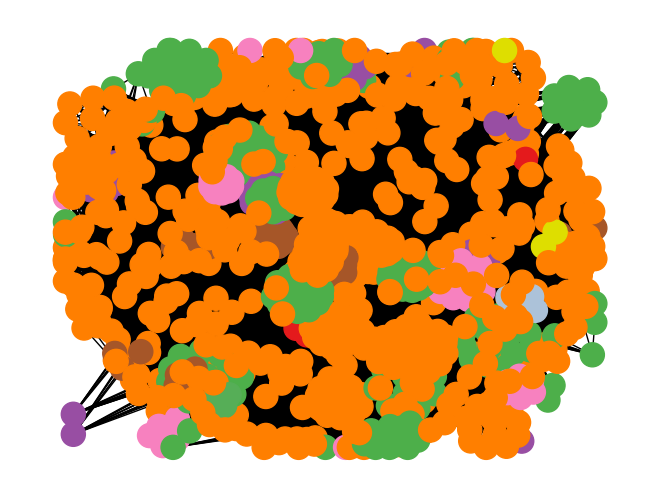

In [10]:
%matplotlib inline
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
nice_colors = [x for x in mcolors.get_named_colors_mapping().values() if isinstance(x, str)] # Nice colors
colors_global = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00'] # color-blind colors
colors_global = colors_global + nice_colors
         
for word, graph in target2graph.items():
    graph = graph.copy()
    print(word)
    print(graph)
    enan=[(u,v) for (u,v,d) in graph.edges(data=True) if np.isnan(d['weight'])]
    graph.remove_edges_from(enan) # Remove nan edges for finding positions        
    # we remove isolated nodes
    graph.remove_nodes_from(list(nx.isolates(graph)))

    # Draw graph
    nx.draw(graph, with_labels=False, font_weight='bold', node_color=np.array(colors_global)[[int(node2cluster[node]) for node in graph.nodes()]])

    # Export inferred edge weights
    labels_inferred = [{'identifier1':'-'.join(u.split('-')[:-1]),'identifier2':'-'.join(v.split('-')[:-1]), 'label':d['weight'], 'lemma':word} for (u,v,d) in graph.edges(data=True)]
    labels_output = output_path + '/labels/{0}/maj_{1}'.format(word, threshold)
    Path(labels_output).mkdir(parents=True, exist_ok=True)
    with open(labels_output+'/labels_proximity.csv'.format(threshold), 'w') as f:  
        w = csv.DictWriter(f, labels_inferred[0].keys(), delimiter='\t', quoting = csv.QUOTE_NONE)
        w.writeheader()
        w.writerows(labels_inferred)

In [11]:
from sklearn.metrics import cohen_kappa_score, hamming_loss, accuracy_score
import krippendorff_ as krippendorff
import csv

stats = []
annotators = ['annotator1', 'annotator2', 'annotator3']
df = df_chiwug_senses[annotators + ['lemma']].replace('None', np.nan).replace('andere', np.nan) # this is not updated, we may have to filter here weird strings annotated by people
df_ = pd.DataFrame()  
df_['lemma'] = df['lemma']
df_[annotators[0]] = df['lemma'] + df[annotators[0]] # prefix senses for uniqueness
df_[annotators[1]] = df['lemma'] + df[annotators[1]]
df_[annotators[2]] = df['lemma'] + df[annotators[2]]
display(df_)
stacked = df_[[annotators[0], annotators[1], annotators[2]]].stack()
df_[[annotators[0], annotators[1], annotators[2]]] = pd.Series(stacked.factorize()[0], index=stacked.index).unstack()
display(df_)
df = df_
indices_1 = df_chiwug_senses[df_chiwug_senses["grouping"]==1].index
indices_2 = df_chiwug_senses[df_chiwug_senses["grouping"]==2].index
df_1 = df.loc[indices_1]
df_2 = df.loc[indices_2]
assert len(df_1) + len(df_2) == len(df)

stats_agree = {}

# Krippendorff     
# Full data   
data = np.transpose(df.loc[:, annotators[0]:annotators[-1]].values)
kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
print('full', kri)
stats_agree['kri_full'] = kri
    
# per time period
data = np.transpose(df_1.loc[:, annotators[0]:annotators[-1]].values)
kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
print('full 1', kri)
stats_agree['kri_full_1'] = kri
data = np.transpose(df_2.loc[:, annotators[0]:annotators[-1]].values)
kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
print('full 2', kri)
stats_agree['kri_full_2'] = kri

# Pairwise
for a, b in combinations(annotators, 2):
    data = [df[a].values, df[b].values]
    kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
    print('full', a, b, kri)
    stats_agree['kri_{0},{1}'.format(a, b)] = kri

# Cohen's kappa and Percentage Agreement
for metric, name in [(cohen_kappa_score, 'cohen_kappa'), (lambda x,y: 1-hamming_loss(x, y), 'ita')]:
    scores = []
    for a, b in combinations(annotators, 2):
        data = df[~df[a].isnull() & ~df[b].isnull()]
        data_a = data[a]
        data_b = data[b]
        if name == 'kri':
            score = metric([data_a, data_b])
        else:            
            score = metric(data_a, data_b)
        print('full', a, b, score)
        scores.append(score)
        stats_agree['{0}_{1},{2}'.format(name, a, b)] = score

    mean = np.mean(scores)    
    print('mean', mean)
    stats_agree['{0}_mean'.format(name)] = mean    

# first some general statistics
stats_agree['judgments_None'] = df_chiwug_senses[[annotators[0], annotators[1], annotators[2]]].stack().eq('None').sum()
stats_agree['judgments_others'] = df_chiwug_senses[[annotators[0], annotators[1], annotators[2]]].stack().eq('andere').sum()
stats_agree['judgments_total'] = (df_chiwug_senses[[annotators[0], annotators[1], annotators[2]]].stack() != 'None').sum()    
stats_agree['avg_judgment_no'] = df_chiwug_senses[[annotators[0], annotators[1], annotators[2]]].apply(lambda x: x!='None', axis = 1).sum(axis=1).mean()    
    
stats.append({'data':'full'} | stats_agree)


# By lemma
scores = []
stats_agree = {}
gb = df.groupby('lemma')
groups = gb.groups
gb1 = df_1.groupby('lemma')
groups1 = gb1.groups
gb2 = df_2.groupby('lemma')
groups2 = gb2.groups
# also group non-processed data frame
gb_full = df_chiwug_senses.groupby('lemma')
groups_full = gb_full.groups
for word in groups.keys():
    
    df_group = gb.get_group(word)

    data = np.transpose(df_group.loc[:, annotators[0]:annotators[-1]].values)
    #print(data)
    try:
        kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
    except AssertionError:
        kri = np.nan
    print(word, kri)
    stats_agree['kri_full'] = kri
     
    df_group1 = gb1.get_group(word)
    data = np.transpose(df_group1.loc[:, annotators[0]:annotators[-1]].values)
    #print(data)
    try:
        kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
    except AssertionError:
        kri = np.nan
    stats_agree['kri_full_1'] = kri    
   
    df_group2 = gb2.get_group(word)
    data = np.transpose(df_group2.loc[:, annotators[0]:annotators[-1]].values)
    try:
        kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
    except AssertionError:
        kri = np.nan
    stats_agree['kri_full_2'] = kri
    
    for a, b in combinations(annotators, 2):
        data = [df_group[a].values, df_group[b].values]
        try:
            kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
        except AssertionError:
            kri = np.nan
        print(word, a, b, kri)
        stats_agree['kri_{0},{1}'.format(a, b)] = kri
    
    for metric, name in [(cohen_kappa_score, 'cohen_kappa'), (lambda x,y: 1-hamming_loss(x, y), 'ita')]:
        scores = []
        for a, b in combinations(annotators, 2):
            data = df_group[~df_group[a].isnull() & ~df_group[b].isnull()]
            score = metric(data[a], data[b])
            print(word, a, b, score)
            scores.append(score)
            stats_agree['{0}_{1},{2}'.format(name, a, b)] = score

        mean = np.nanmean(scores)    
        print('mean', mean)
        stats_agree['{0}_mean'.format(name)] = mean
    
    # some general statistics
    df_group_full = gb_full.get_group(word)
    stats_agree['judgments_None'] = df_group_full[[annotators[0], annotators[1], annotators[2]]].stack().eq('None').sum()
    stats_agree['judgments_others'] = df_group_full[[annotators[0], annotators[1], annotators[2]]].stack().eq('andere').sum()
    stats_agree['judgments_total'] = (df_group_full[[annotators[0], annotators[1], annotators[2]]].stack() != 'None').sum()    
    stats_agree['avg_judgment_no'] = df_group_full[[annotators[0], annotators[1], annotators[2]]].apply(lambda x: x!='None', axis = 1).sum(axis=1).mean()    
    stats.append({'data':word} | stats_agree)
   
    
# Export stats
stats_output = output_path + '/stats'
Path(stats_output).mkdir(parents=True, exist_ok=True)
with open(stats_output+'/stats_agreement.csv', 'w') as f:  
    w = csv.DictWriter(f, stats[0].keys(), delimiter='\t', quoting = csv.QUOTE_NONE)
    w.writeheader()
    w.writerows(stats)

,lemma,annotator1,annotator2,annotator3
0,炒,炒1,炒1,炒1
1,炒,炒1,炒1,炒1
2,炒,炒1,炒1,炒1
3,炒,炒1,炒1,炒1
4,炒,炒1,炒1,炒1
...,...,...,...,...
1595,机制,机制1,机制1,机制1
1596,机制,机制3,机制3,机制3
1597,机制,机制1,机制1,机制1
1598,机制,机制4,机制4,机制5


,lemma,annotator1,annotator2,annotator3
0,炒,0.0,0.0,0.0
1,炒,0.0,0.0,0.0
2,炒,0.0,0.0,0.0
3,炒,0.0,0.0,0.0
4,炒,0.0,0.0,0.0
...,...,...,...,...
1595,机制,170.0,170.0,170.0
1596,机制,168.0,168.0,168.0
1597,机制,170.0,170.0,170.0
1598,机制,169.0,169.0,167.0


full 0.8685480407289289
full 1 0.8534907336512282
full 2 0.8832403879415363
full annotator1 annotator2 0.8760133058415983
full annotator1 annotator3 0.8721047664843169
full annotator2 annotator3 0.8731178284924404
full annotator1 annotator2 0.8759944952519643
full annotator1 annotator3 0.8720827732249542
full annotator2 annotator3 0.8731005651892902
mean 0.8737259445554028
full annotator1 annotator2 0.8779857972885733
full annotator1 annotator3 0.8741168914579319
full annotator2 annotator3 0.8751625487646294
mean 0.8757550791703782
下海 0.7757127771911299
下海 annotator1 annotator2 0.8081714000996513
下海 annotator1 annotator3 0.7793296089385474
下海 annotator2 annotator3 0.7380952380952381
下海 annotator1 annotator2 0.8063555114200596
下海 annotator1 annotator3 0.7767441860465116
下海 annotator2 annotator3 0.7354651162790697
mean 0.7728549379152136
下海 annotator1 annotator2 0.8717948717948718
下海 annotator1 annotator3 0.85
下海 annotator2 annotator3 0.8205128205128205
mean 0.8474358974358974
体系 nan
体系 

/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k

停业 0.16305916305916313
停业 annotator1 annotator2 0.7123719464144995
停业 annotator1 annotator3 -0.11442006269592464
停业 annotator2 annotator3 -0.2586206896551724
停业 annotator1 annotator2 0.714064914992272
停业 annotator1 annotator3 -0.014084507042253502
停业 annotator2 annotator3 -0.22821576763485463
mean 0.15725488010505462
停业 annotator1 annotator2 0.8648648648648649
停业 annotator1 annotator3 0.55
停业 annotator2 annotator3 0.5675675675675675
mean 0.6608108108108108
储粮 nan
储粮 annotator1 annotator2 nan
储粮 annotator1 annotator3 nan
储粮 annotator2 annotator3 nan
储粮 annotator1 annotator2 nan
储粮 annotator1 annotator3 nan
储粮 annotator2 annotator3 nan
mean nan
储粮 annotator1 annotator2 1.0
储粮 annotator1 annotator3 1.0
储粮 annotator2 annotator3 1.0
mean 1.0
出血 0.6842809364548494
出血 annotator1 annotator2 0.6327503974562798
出血 annotator1 annotator3 0.6367924528301887
出血 annotator2 annotator3 0.7771509167842031
出血 annotator1 annotator2 0.629746835443038
出血 annotator1 annotator3 0.6332288401253918
出血 annotator

/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k

留下 annotator1 annotator2 1.0
留下 annotator1 annotator3 1.0
留下 annotator2 annotator3 1.0
mean 1.0
病毒 0.5886075949367089
病毒 annotator1 annotator2 0.6503496503496504
病毒 annotator1 annotator3 0.5688949522510232
病毒 annotator2 annotator3 0.6981891348088531
病毒 annotator1 annotator2 0.6465116279069767
病毒 annotator1 annotator3 0.568733153638814
病毒 annotator2 annotator3 0.696
mean 0.6370815938485969
病毒 annotator1 annotator2 0.9473684210526316
病毒 annotator1 annotator3 0.9
病毒 annotator2 annotator3 0.9473684210526316
mean 0.9315789473684211
窗口 0.6952945677123181
窗口 annotator1 annotator2 0.6915887850467289
窗口 annotator1 annotator3 0.7011349306431274
窗口 annotator2 annotator3 0.7213930348258706
窗口 annotator1 annotator2 0.6912928759894459
窗口 annotator1 annotator3 0.6984924623115578
窗口 annotator2 annotator3 0.7189189189189189
mean 0.7029014190733075
窗口 annotator1 annotator2 0.7692307692307692
窗口 annotator1 annotator3 0.775
窗口 annotator2 annotator3 0.7948717948717949
mean 0.7797008547008547
窗户 0.157223796

/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k

输血 0.8576555023923444
输血 annotator1 annotator2 0.9447938504542278
输血 annotator1 annotator3 0.7893333333333333
输血 annotator2 annotator3 0.8439763001974984
输血 annotator1 annotator2 0.9441340782122905
输血 annotator1 annotator3 0.7889182058047494
输血 annotator2 annotator3 0.8429319371727748
mean 0.8586614070632717
输血 annotator1 annotator2 0.975
输血 annotator1 annotator3 0.9
输血 annotator2 annotator3 0.925
mean 0.9333333333333332
退役 0.9382239382239382
退役 annotator1 annotator2 0.9538850284270373
退役 annotator1 annotator3 0.9534735500318674
退役 annotator2 annotator3 0.9071207430340558
退役 annotator1 annotator2 0.9532828282828283
退役 annotator1 annotator3 0.9528662420382166
退役 annotator2 annotator3 0.905940594059406
mean 0.9373632214601503
退役 annotator1 annotator2 0.972972972972973
退役 annotator1 annotator3 0.972972972972973
退役 annotator2 annotator3 0.9473684210526316
mean 0.9644381223328592
透明 0.9098143236074271
透明 annotator1 annotator2 0.9318377911993098
透明 annotator1 annotator3 0.9318377911993098
透明

/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/users0/schlecdk/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/tmp/ipykernel_1955788/2990419486.py:138: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(scores)


In [12]:
# Export annotators
annotators_out = [{'annotator': annotator} for annotator in annotators]
stats_output = output_path 
Path(stats_output).mkdir(parents=True, exist_ok=True)
with open(stats_output+'/annotators.csv', 'w') as f:  
    w = csv.DictWriter(f, annotators_out[0].keys(), delimiter='\t', quoting = csv.QUOTE_NONE)
    w.writeheader()
    w.writerows(annotators_out)